In [0]:
#Importación de librerías
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.functions import expr, col, column, monotonically_increasing_id, desc, when
import tensorflow as tf
from tensorflow import keras
from itertools import chain
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from pyspark.sql.types import StringType

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from sklearn.preprocessing import OneHotEncoder
import datetime
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from unicodedata import normalize
import re
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from petastorm.spark import SparkDatasetConverter, make_spark_converter
from petastorm import TransformSpec
import contexto
from contexto.limpieza import *
from contexto.lectura import leer_texto
from contexto.limpieza import limpieza_texto, lista_stopwords, remover_stopwords
from contexto.exploracion import grafica_barchart_frecuencias
from contexto.exploracion import obtener_ngramas, par_nubes
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import text
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing import sequence
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Bidirectional, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.metrics import precision_score
from tensorflow.keras. metrics import FalseNegatives, FalsePositives, TrueNegatives
from tensorflow.keras. metrics import TruePositives, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import regularizers

In [0]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0

In [0]:
# ## Importación de base de trabajo resultado de script cruce_limpieza
# storage_account = "blobName"
# container = "basecruzada"
# blobKey = "blobKey"
# blobEndpoint = "wasbs://{1}@{0}.blob.core.windows.net/".format(storage_account, container)

# try:
#   dbutils.fs.mount(
#     source = blobEndpoint,
#     mount_point = "/mnt/basecruzada",
#     extra_configs = {"fs.azure.account.key.{0}.blob.core.windows.net".format(storage_account):blobKey})
# except:
#   print("Already mounted. Unmounting and trying to mount again")
#   dbutils.fs.unmount(mount_point='/mnt/basecruzada')
#   dbutils.fs.mount(
#     source = blobEndpoint,
#     mount_point = "/mnt/basecruzada",
#     extra_configs = {"fs.azure.account.key.{0}.blob.core.windows.net".format(storage_account):blobKey})

# 1) Preprocesamiento de datos

In [0]:
# Leer archivo parquet que corresponde a la base resultado del script "2_Limpieza_y_creacionde_variables"
file = "/mnt/basecruzada/baselimpia.parquet"
DF_modelo = spark.read.parquet(file)

In [0]:
#Filtrar datos para que solo contengan información de mayo 2020 para atrás, fecha de corte definida para los datos de entrenamiento del modelo. Esto porque los datos fueron recolectados con fecha de corte mayo de 2021, y se tomó como criterio que debía trascurrir un año para que el posible proceso de una petición complete su curso (por ejemplo, si llega hasta el punto de la apertura de un Proceso Administrativo de Restablecimiento de Derechos - PARD)  Esto podría conducir a errores en la clasificación inducidos dentro del entrenamiento.
print((DF_modelo.count(), len(DF_modelo.columns)))
DF_modelo = DF_modelo.filter((col("AnoRegistroPeticion") != "2021"))
print((DF_modelo.count(), len(DF_modelo.columns)))
DF_modelo = DF_modelo.filter((col("AnoRegistroPeticion") != "2020") | ~(col("MesRegistroPeticion").isin(["Jun", "Jul", "Aug", "Sep", "Oct","Nov","Dec"])))
print((DF_modelo.count(), len(DF_modelo.columns)))

(1163243, 118)
(1088405, 118)
(982085, 118)

In [0]:
# Crea en Spark un mapeo de los keys del diccionario a los values. Esto se hace para generar la variable objetivo con la que se realizará el entrenamiento
dicc_varoobj = {"falsa": 0, "sindefinir_fallida":1, "verdadera_nopard":2, "verdadera_pard_noinst":3, "verdadera_pard_inst":4}

mapping_expr = F.create_map([F.lit(x) for x in chain(*dicc_varoobj.items())])
print(DF_modelo.groupby("VAR_OBJETIVO").count().sort("count", ascending=False).show())
DF_modelo = DF_modelo.withColumn("VAR_OBJETIVO", mapping_expr[col("VAR_OBJETIVO")])
print(DF_modelo.groupby("VAR_OBJETIVO").count().sort("count", ascending=False).show())

+--------------------+------+
 VAR_OBJETIVO| count|
+--------------------+------+
 verdadera_nopard|307642|
 falsa|304135|
 sindefinir_fallida|170111|
verdadera_pard_no...|137667|
 verdadera_pard_inst| 62530|
+--------------------+------+

None
+------------+------+
VAR_OBJETIVO| count|
+------------+------+
 2|307642|
 0|304135|
 1|170111|
 3|137667|
 4| 62530|
+------------+------+

None

In [0]:
##Preseleccionar variables con las que se realizará entrenamiento

columnas_mantener = ['AnoRegistroPeticion', 'MesRegistroPeticion', 'MotivoPeticion', 'CanalRecepcion','TipoDocumentoPeticionario', 'EdadPeticionario', 'SexoPeticionario', 'TipoDocumentoAfectado', 'SexoAfectado', 'GrupoEtnicoAfectado', 'PresentaDiscapacidadAfectado', 'CondicionDesplazamientoAfectado', 'horaRegistroPeticion', 'minutoRegistroPeticion', 'VAR_OBJETIVO', 'PaisAfectado_5', 'X', 'Y', 'porc_etnica_2018', 'porc_indigena_2018', 'tasa_vip_total', 'tasa_vif_total', 'TasaFecunidad_15a19', 'porc_rural', 'vict_delsexual_total',  'EdadAfectado_Anios_Imputada','DescripcionPeticion','TipoPeticion','CategorizacionPeticionario','SinSuficienteInfo_Afectado','DetalleZonAfectado','DetalleZonaPeticionario']

DF_modelo = DF_modelo.select(columnas_mantener)

In [0]:
###Convertir set de datos a Pandas para poder entrenar el modelo de redes neuronales con TensorFlow Keras
DF_modelo_pd = DF_modelo.toPandas()

Out[8]:

,AnoRegistroPeticion,MesRegistroPeticion,MotivoPeticion,CanalRecepcion,TipoDocumentoPeticionario,EdadPeticionario,SexoPeticionario,TipoDocumentoAfectado,SexoAfectado,GrupoEtnicoAfectado,PresentaDiscapacidadAfectado,CondicionDesplazamientoAfectado,horaRegistroPeticion,minutoRegistroPeticion,VAR_OBJETIVO,PaisAfectado_5,X,Y,porc_etnica_2018,porc_indigena_2018,tasa_vip_total,tasa_vif_total,TasaFecunidad_15a19,porc_rural,vict_delsexual_total,EdadAfectado_Anios_Imputada,DescripcionPeticion,TipoPeticion,CategorizacionPeticionario,SinSuficienteInfo_Afectado,DetalleZonAfectado,DetalleZonaPeticionario
0,2019,Apr,Maltrato,Telefónico Verbal,ND,ND,ND,RC o PB,F,ND,ND,ND,16,44,3,COLOMBIA,-75.382462,9.303727,24.884264,12.139540,165.218381,116.923777,94.059773,37.107717,82.995989,3.175,Se comunica denunciante reportando el caso de ...,Reporte de Amenaza o Vulneración de derechos,Anonimo,ConInfo,Urbana,Urbana
1,2019,Apr,Maltrato,Telefónico Verbal,ND,ND,ND,RC o PB,M,ND,ND,ND,19,39,2,COLOMBIA,-75.382462,9.303727,24.884264,12.139540,165.218381,116.923777,94.059773,37.107717,82.995989,1.809,Se comunica denunciante informando el caso de ...,Reporte de Amenaza o Vulneración de derechos,Anonimo,ConInfo,Urbana,Urbana
2,2019,Aug,Maltrato,Telefónico Verbal,CC,ND,F,RC o PB,M,ND,ND,ND,10,7,0,COLOMBIA,-75.382462,9.303727,24.884264,12.139540,165.218381,116.923777,94.059773,37.107717,82.995989,4.753,Se comunica la señora Kelly Johanna Bonilla Ma...,Solicitud de Restablecimiento de Derechos (SRD),Familiar,ConInfo,Urbana,Urbana
3,2019,Sep,Maltrato,Escrito,ND,ND,M,RC o PB,F,ND,ND,ND,12,10,2,COLOMBIA,-75.382462,9.303727,24.884264,12.139540,165.218381,116.923777,94.059773,37.107717,82.995989,4.000,Se recibe oficio con número de radicado E-2019...,Solicitud de Restablecimiento de Derechos (SRD),Otro,ConInfo,Urbana,Urbana
4,2019,Mar,Maltrato,Escrito,ND,ND,F,RC o PB,F,ND,ND,ND,12,43,2,COLOMBIA,-75.382462,9.303727,24.884264,12.139540,165.218381,116.923777,94.059773,37.107717,82.995989,1.347,Se recibe solicitud con Radicado No E-2019-106...,Solicitud de Restablecimiento de Derechos (SRD),Policia_Fiscalia,ConInfo,Urbana,Urbana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982080,2017,Aug,Trata,Escrito,ND,ND,F,"CE, PASAPORTE, PEP O VISA",M,ND,ND,ND,16,55,2,OTRO,-74.098877,4.655856,3.191046,0.265447,373.240735,271.349439,50.857820,0.320165,79.414671,18.000,Se recibe oficio de fecha 08/29/2017 del tenie...,Solicitud de Restablecimiento de Derechos (SRD),Otro,ConInfo,Urbana,Urbana
982081,2019,Dec,Trata,Telefónico Verbal,ND,ND,ND,"CE, PASAPORTE, PEP O VISA",M,ND,ND,ND,22,31,2,COLOMBIA,4.641427,-74.094736,3.191046,0.265447,395.746898,271.403992,41.203348,0.339505,105.914740,0.167,Se comunica peticionario reportando la situaci...,Reporte de Amenaza o Vulneración de derechos,Anonimo,ConInfo,Urbana,Urbana
982082,2019,Nov,Trata,Telefónico Verbal,ND,ND,ND,"CE, PASAPORTE, PEP O VISA",M,ND,ND,ND,13,54,2,COLOMBIA,4.641427,-74.094736,3.191046,0.265447,395.746898,271.403992,41.203348,0.339505,105.914740,9.000,Se comunica peticionario reportando la situaci...,Reporte de Amenaza o Vulneración de derechos,Anonimo,ConInfo,Urbana,Urbana
982083,2019,Oct,Trata,Telefónico Verbal,ND,ND,ND,"CE, PASAPORTE, PEP O VISA",ND,ND,ND,ND,16,25,4,COLOMBIA,-74.094170,4.612551,3.191046,0.265447,395.746898,271.403992,41.203348,0.339505,105.914740,16.000,Se comunica peticionario dando a conocer la si...,Solicitud de Restablecimiento de Derechos (SRD),Anonimo,SinInfo,Urbana,Urbana


In [0]:
##Eliminar nulos. Esta es una operación importante para evitar que las redes neuronales generen errores al realizar el entrenamiento.
DF_modelo_pd = DF_modelo_pd.dropna()

In [0]:
# Con el objetivo de que el preprocesamiento de las variables se pueda reutilizar al momento de predecir datos nuevos en el script "5_Prediccion_NuevosDatos", se definirán pipelines para el preprocesamiento de la variables de texto ("DescripcionPeticion") y numéricas
# Para que los métodos de fit_on_text y text_to_squences sirvan dentro del pipeline se deben definir clases para redefinirlas como métodos de fit y transform

class LimpiarTexto(BaseEstimator, TransformerMixin):

    def __init__(self):
        self

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_clean=X.str.lower()
        X_clean=X_clean.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
        X_clean = X_clean.str.replace('<.*?>', '', regex=True)
        X_clean = X_clean.str.replace(':.*?:', '', regex=True)
        X_clean = X_clean.str.replace('[^a-z ]', '', regex=True)
        return X_clean

class TokenizerTransformer(BaseEstimator, TransformerMixin, Tokenizer):
    def __init__(self, **tokenizer_params):
        Tokenizer.__init__(self, **tokenizer_params)

    def fit(self, X, y=None):
        self.fit_on_texts(X)
        return self

    def transform(self, X, y=None):
        X_transformed = self.texts_to_sequences(X)
        return X_transformed
      
class PadSequencesTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, maxlen):
        self.maxlen = maxlen

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_padded = pad_sequences(X, maxlen=self.maxlen)
        return X_padded

In [0]:
# Se crean variables para las clases creadas en la celda anterior y se define el pipeline
my_cleaner = LimpiarTexto()
my_tokenizer = TokenizerTransformer(num_words=3000)
my_padder = PadSequencesTransformer(maxlen=200)

pipeline = Pipeline([
  ('textcleaner', my_cleaner),
  ('tokenizer', my_tokenizer),
  ('padder', my_padder)
])

In [0]:
# Se aplica el pipeline para el preprocesamiento de texto en la variable "DescripcionPeticion"
x_texto=pd.DataFrame(DF_modelo_pd.loc[:,"DescripcionPeticion"])
save_pipeline_text = pipeline.fit(x_texto["DescripcionPeticion"])

In [0]:
# Se guarda el pipeline de preprocesamiento de texto para poder reutilizarlo después
import mlflow
import mlflow.sklearn
with mlflow.start_run():
  mlflow.sklearn.log_model(save_pipeline_text, "nn_text_pipeline")

In [0]:
# Hacer transformación de variable de texto con pipeline entrenado
padded_sequence = pipeline.transform(x_texto["DescripcionPeticion"])

In [0]:
# Se define un tamaño de vocabulario para el embedding dentro de la red.
vocab_size = 479598
vocab_size

Out[16]: 479598

In [0]:
# Se crea igualmente un pipeline para el preprocesamiento de las variables numéricas, cuyo único paso es la estandarización para que tengan media 0 y varianza 1
scaler = StandardScaler()
numeric_pipeline = Pipeline([('numeric_scaler', scaler)])

# Se definen las variables numéricas que pasan por el preprocesamiento y se realiza fit del pipeline definido
numeric_feature_names = ['AnoRegistroPeticion', 'horaRegistroPeticion', 'minutoRegistroPeticion', 'X', 'Y', 'porc_etnica_2018', 'porc_indigena_2018', 'tasa_vip_total', 'tasa_vif_total', 'TasaFecunidad_15a19', 'porc_rural', 'vict_delsexual_total',  'EdadAfectado_Anios_Imputada']
numeric_features = DF_modelo_pd[numeric_feature_names]
save_pipeline_num = numeric_pipeline.fit(numeric_features)

# Se guarda Pipeline con MLflow para poderlo reutilizar posteriormente
with mlflow.start_run():
  mlflow.sklearn.log_model(save_pipeline_num, "nn_num_pipeline")

# Hacer transformación de datos numéricos con pipeline entrenado
numeric_features = numeric_pipeline.transform(numeric_features)
numeric_features_tf = tf.convert_to_tensor(numeric_features)

In [0]:
# Finalmente se hace preprocesamiento de las variables categóricas, haciendo one-hot encoding con el método get_dummies de pandas
categorical_feature_names = ['MesRegistroPeticion', 'MotivoPeticion', 'CanalRecepcion','TipoDocumentoPeticionario', 'EdadPeticionario', 'SexoPeticionario',  'TipoDocumentoAfectado', 'SexoAfectado', 'GrupoEtnicoAfectado', 'PresentaDiscapacidadAfectado', 'CondicionDesplazamientoAfectado', 'PaisAfectado_5','TipoPeticion','CategorizacionPeticionario','SinSuficienteInfo_Afectado','DetalleZonAfectado','DetalleZonaPeticionario']

categorical_features=DF_modelo_pd[categorical_feature_names]
categorical_features = pd.get_dummies(categorical_features)
categorical_features_tf=tf.convert_to_tensor(categorical_features)

# Obtener columnas creadas a partir de one-hot encoding para poder utilizar estas columnas al hacer el predict con nuevos datos
print(list(categorical_features.columns))

['MesRegistroPeticion_Apr', 'MesRegistroPeticion_Aug', 'MesRegistroPeticion_Dec', 'MesRegistroPeticion_Feb', 'MesRegistroPeticion_Jan', 'MesRegistroPeticion_Jul', 'MesRegistroPeticion_Jun', 'MesRegistroPeticion_Mar', 'MesRegistroPeticion_May', 'MesRegistroPeticion_Nov', 'MesRegistroPeticion_Oct', 'MesRegistroPeticion_Sep', 'MotivoPeticion_Abandono_Amenaza', 'MotivoPeticion_Conductas_Adolescentes', 'MotivoPeticion_Desvinculados', 'MotivoPeticion_ESCNNA', 'MotivoPeticion_Maltrato', 'MotivoPeticion_ND', 'MotivoPeticion_NNA_solo', 'MotivoPeticion_Otro', 'MotivoPeticion_PI_Vulnerable', 'MotivoPeticion_Permanencia_Calle', 'MotivoPeticion_TI', 'MotivoPeticion_Trata', 'MotivoPeticion_V_sexual', 'CanalRecepcion_Chat', 'CanalRecepcion_Click to Call', 'CanalRecepcion_Correo Electrónico', 'CanalRecepcion_Escrito', 'CanalRecepcion_Portal', 'CanalRecepcion_Presencial Verbal', 'CanalRecepcion_Redes Sociales', 'CanalRecepcion_Telefónico Verbal', 'CanalRecepcion_VideoLlamada', 'CanalRecepcion_Web Service', 'CanalRecepcion_WhatsApp', 'TipoDocumentoPeticionario_CC', 'TipoDocumentoPeticionario_CE, PASAPORTE, PEP O VISA', 'TipoDocumentoPeticionario_DANE, NIT O RUT', 'TipoDocumentoPeticionario_ND', 'TipoDocumentoPeticionario_RC o PB', 'TipoDocumentoPeticionario_TI', 'EdadPeticionario_17omenos', 'EdadPeticionario_18_24', 'EdadPeticionario_25_27', 'EdadPeticionario_28_30', 'EdadPeticionario_31_32', 'EdadPeticionario_33_35', 'EdadPeticionario_36_38', 'EdadPeticionario_39_42', 'EdadPeticionario_43_48', 'EdadPeticionario_49omayor', 'EdadPeticionario_ND', 'SexoPeticionario_F', 'SexoPeticionario_M', 'SexoPeticionario_ND', 'TipoDocumentoAfectado_CC', 'TipoDocumentoAfectado_CE, PASAPORTE, PEP O VISA', 'TipoDocumentoAfectado_DANE, NIT O RUT', 'TipoDocumentoAfectado_ND', 'TipoDocumentoAfectado_RC o PB', 'TipoDocumentoAfectado_TI', 'SexoAfectado_F', 'SexoAfectado_M', 'SexoAfectado_ND', 'GrupoEtnicoAfectado_AFROCOLOMBIANO (A)', 'GrupoEtnicoAfectado_INDÍGENA', 'GrupoEtnicoAfectado_ND', 'GrupoEtnicoAfectado_PALENQUERO (A)', 'GrupoEtnicoAfectado_RAIZAL', 'GrupoEtnicoAfectado_ROM/GITANO', 'PresentaDiscapacidadAfectado_ND', 'PresentaDiscapacidadAfectado_Si', 'CondicionDesplazamientoAfectado_ND', 'CondicionDesplazamientoAfectado_S', 'PaisAfectado_5_ARMENIA', 'PaisAfectado_5_COLOMBIA', 'PaisAfectado_5_ESPAÑA', 'PaisAfectado_5_ND', 'PaisAfectado_5_OTRO', 'PaisAfectado_5_VENEZUELA', 'TipoPeticion_Reporte de Amenaza o Vulneración de derechos', 'TipoPeticion_Solicitud de Restablecimiento de Derechos (SRD)', 'CategorizacionPeticionario_Anonimo', 'CategorizacionPeticionario_Colegio', 'CategorizacionPeticionario_Ejecutivo', 'CategorizacionPeticionario_Familiar', 'CategorizacionPeticionario_Fundacion_ONG', 'CategorizacionPeticionario_Hospital_Clinica', 'CategorizacionPeticionario_ICBF', 'CategorizacionPeticionario_Judicial', 'CategorizacionPeticionario_MinisterioPublico_HogarDePaso', 'CategorizacionPeticionario_MismoAfectado', 'CategorizacionPeticionario_Otro', 'CategorizacionPeticionario_Policia_Fiscalia', 'SinSuficienteInfo_Afectado_ConInfo', 'SinSuficienteInfo_Afectado_SinInfo', 'DetalleZonAfectado_Rural', 'DetalleZonAfectado_Urbana', 'DetalleZonaPeticionario_Rural', 'DetalleZonaPeticionario_Urbana']

In [0]:
###### Dividir datos entre Entrenamiento, Evaluación y Validación

# Definir variable objetivo y separar entre Entrenamiento, Evaluación y Validación
y = DF_modelo_pd.pop("VAR_OBJETIVO")
train_y = pd.DataFrame(train_y)

# Separar variables explicativas en Entrenamiento (80%) y Evaluación (20%)
train_xtext, test_xtext = train_test_split( padded_sequence, test_size=0.2,random_state=42,stratify=y)
train_xnumeric, test_xnumeric, train_y, test_y = train_test_split(numeric_features, y,test_size=0.2,random_state=42,stratify=y)
train_xcategoric, test_xcategoric = train_test_split(categorical_features, test_size=0.2,random_state=42,stratify=y)

# Separar datos de Validación que son el 10% de los de Entrenamiento
train_xtext,val_xtext=train_test_split(train_xtext, test_size=0.1, random_state=42, shuffle=True, stratify=train_y["VAR_OBJETIVO"])
train_xnumeric,val_xnumeric=train_test_split(train_xnumeric, test_size=0.1, random_state=42, shuffle=True,stratify=train_y["VAR_OBJETIVO"])
train_xcategoric, val_xcategoric=train_test_split(train_xcategoric, test_size=0.1, random_state=42, shuffle=True, stratify=train_y["VAR_OBJETIVO"])
train_y, val_y=train_test_split(train_y, test_size=0.1, random_state=42, shuffle=True, stratify=train_y["VAR_OBJETIVO"])

# Mostrar tamaño de los datos de entrenamiento
print(train_xtext.shape)
print(train_xnumeric.shape)
print(train_xcategoric.shape)
print(train_y.shape)

(707079, 200)
(707079, 13)
(707079, 101)
(707079, 1)

# 2) Definición de modelos de redes neuronales
Inicialmente se definen parámetros generales para todos los modelos: métricas y pesos diferenciados para cada categoría de clasificación

In [0]:
###### Se definen métricas con las que vamos a evaluar el modelo
metrics = [
    FalseNegatives(name="fn"),
    FalsePositives(name="fp"),
    TrueNegatives(name="tn"),
    TruePositives(name="tp"),
    Precision(name="precision"),
    Recall(name="recall"),
]

In [0]:
# Crea los pesos para el entrenamiento. Más peso a las categorías menos frecuentes. Estos pesos se obtienen como el inverso del conteo de cada categoría de la variable objetivo. Esto se realiza para garantizar un buen ajuste en las categorías menos frecuentes (verdaderas PARD Institucional, por ejemplo)

train_y2 = train_y.VAR_OBJETIVO.values
counts = np.bincount(train_y2)

weight_for_0 = 1.0 / counts[0] # Falsas
weight_for_1 = 1.0 / counts[1] # Sin definir o fallidas
weight_for_2 = 1.0 / counts[2] # Verdaderas no PARD
weight_for_3 = 1.0 / counts[3] # Verdaderas PARD no Institucional
weight_for_4 = 1.0 / counts[4] # Verdaderas PARD Institucional

print(weight_for_0)
print(weight_for_1)
print(weight_for_2)
print(weight_for_3)
print(weight_for_4)

4.566814783692818e-06
8.16499828535036e-06
4.5147949831598144e-06
1.0088781275221954e-05
2.2212350066637052e-05

## 2.1) Red 1: Modelo concatenado después de hacer entrenamiento separado y diferenciado para las v. numéricas, categóricas y de texto

In [0]:
#Este modelo integra el embedding dentro de la red a través de una red LSTM bidireccional. La red se diseña para que haga un entrenamiento previo de cada tipo de variable de forma separada a través de redes poco profundas. El entubamiento de las variables numéricas contiene un "BatchNormalization", que es uno de los métodos usados para evitar un sobreentrenamiento. Además, el entubamiento de las variables categóricas incluye un mayor número de capas debido a su mayor tamaño (sin embargo, se usa un dropout del 15% para evitar sobreentrenamiento también). Finalmente, los outputs de los tres sistemas de redes con orígenes y entrenamientos iniciales diferentes se unen o concatenan para hacer la clasificación de las 5 categorías. Se optimiza con Adam.

embedding_vector_length = 32

model1_in = Input(shape=(200,))
emb = Embedding(vocab_size, embedding_vector_length,input_length=200)(model1_in) 
model1_out = Bidirectional(LSTM(50))(emb)

model2_in = Input(shape=(13,))
dense1=Dense(32,input_shape=(13,))(model2_in)
dense2=Dense(32,activation='relu')(dense1)
norma1=BatchNormalization()(dense2)
model2_out = (norma1)

model3_in=Input(shape=(101,))
dense1=Dense(512, activation='relu')(model3_in)
dense2=Dense(256, activation='relu')(dense1)
dense3=Dense(128, activation='relu')(dense2)
dense4=Dense(128, activation='relu')(dense3)
drop=Dropout(0.15)(dense4)
model3_out=(drop)

concat = concatenate([model1_out, model2_out, model3_out])
classifier = Dense(128, activation='relu')(concat) 
out = Dense(5, activation='softmax', name='output_layer')(classifier)

merged_model = Model([model1_in, model2_in, model3_in], out)
merged_model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', 
metrics=['accuracy'])

print(merged_model.summary())

In [0]:
####Se define un class_weight, batch_size y num_epochs y otros parámetros para ajustar el entrenamiento

BATCH_SIZE = 32
NUM_EPOCHS = 100

#Class Weights
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4 }
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [0]:
######Guardar lo modelos automáticamente con MLflow. Una vez se ejecuta, todos los modelos entrenados se empizan a guardar en Experiment
import mlflow.tensorflow
mlflow.tensorflow.autolog()

In [0]:
###Hacer fit de red neuronal # 1
history = merged_model.fit([train_xtext,train_xnumeric, train_xcategoric],y=train_y,validation_split=0.2, epochs=NUM_EPOCHS,class_weight=class_weight, callbacks=[callback],
                           batch_size=BATCH_SIZE,shuffle=True,verbose=1)

In [0]:
##Aquí se hacen las predicciones del modelo de red neuronal # 1 
test_predictions_baseline = merged_model.predict([test_xtext,test_xnumeric, test_xcategoric], batch_size=BATCH_SIZE)
test_predictions_baseline

In [0]:
## Estas líneas de código permiten establecer la categoría predicha por el modelo
data_preds = pd.DataFrame({"label_pred": np.argmax(test_predictions_baseline, axis=1), "label_true":test_y, "pred_0":test_predictions_baseline[:,0], "pred_1":test_predictions_baseline[:,1], "pred_2":test_predictions_baseline[:,2], "pred_3":test_predictions_baseline[:,3], "pred_4":test_predictions_baseline[:,4]})

In [0]:
## Generación de la matriz de confusión del modelo de red neuronal #1
cm = confusion_matrix(data_preds["label_true"], data_preds["label_pred"])
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix ')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Out[27]:

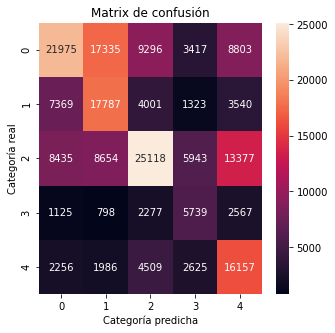

Text(0.5, 24.0, 'Categoría predicha')

In [0]:
cm = confusion_matrix(data_preds["label_true"], data_preds["label_pred"])
plt.figure(figsize=(5,5))
xlabels = ["Falsa", "Sin Definir o Fallida", "Verdadera No PARD", "Verdadera PARD No Institucional", "Verdadera PARD Institucional"]
ylabels = xlabels
sns.heatmap(cm, annot=True, fmt="d", xticklabels=xlabels, yticklabels=ylabels)
plt.title('Matrix de confusión')
plt.ylabel('Categoría real')
plt.xlabel('Categoría predicha')

## 2.2) Red 2: Modelo que conecta a las mismas neuronas desde el principio los distintos tipos de variables

In [0]:
#Este modelo a diferencia del primero, solo entuba de forma separada los diferentes tipos de variables. A partir de allí conecta los tensores a las mismas neuronas. No se usa ningún tipo de regularización (ni dropout, ni batch, etc). Se compila con Adam

model1_in = Input(shape=(200,))
emb = Embedding(vocab_size, embedding_vector_length, input_length=200)(model1_in) 
model1_out = Bidirectional(LSTM(50))(emb)

model2_in = Input(shape=(13,))
model2_out = (model2_in)

model3_in=Input(shape=(101,))
model3_out=(model3_in)

concat = concatenate([model1_out, model2_out, model3_out])
dense1= Dense(1024, activation='relu') (concat)
dense2= Dense(512, activation='relu') (dense1)
dense3= Dense(512, activation='relu') (dense2)
dense4= Dense(256, activation='relu') (dense3)
classifier = Dense(128, activation='relu') (dense4)   
out = Dense(5, activation='softmax', name='output_layer')(classifier)

merged_model2 = Model([model1_in, model2_in, model3_in], out)
merged_model2.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', 
metrics=['accuracy'])

print(merged_model2.summary())

Model: "model_11"
__________________________________________________________________________________________________
Layer (type) Output Shape Param # Connected to 
==================================================================================================
input_38 (InputLayer) [(None, 200)] 0 
__________________________________________________________________________________________________
embedding_13 (Embedding) (None, 200, 32) 15347136 input_38[0][0] 
__________________________________________________________________________________________________
bidirectional_13 (Bidirectional (None, 100) 33200 embedding_13[0][0] 
__________________________________________________________________________________________________
input_39 (InputLayer) [(None, 13)] 0 
__________________________________________________________________________________________________
input_40 (InputLayer) [(None, 101)] 0 
__________________________________________________________________________________________________
concatenate_12 (Concatenate) (None, 214) 0 bidirectional_13[0][0] 
 input_39[0][0] 
 input_40[0][0] 
__________________________________________________________________________________________________
dense_69 (Dense) (None, 1024) 220160 concatenate_12[0][0] 
__________________________________________________________________________________________________
dense_70 (Dense) (None, 512) 524800 dense_69[0][0] 
__________________________________________________________________________________________________
dense_71 (Dense) (None, 512) 262656 dense_70[0][0] 
__________________________________________________________________________________________________
dense_72 (Dense) (None, 256) 131328 dense_71[0][0] 
__________________________________________________________________________________________________
dense_73 (Dense) (None, 128) 32896 dense_72[0][0] 
__________________________________________________________________________________________________
output_layer (Dense) (None, 5) 645 dense_73[0][0] 
==================================================================================================
Total params: 16,552,821
Trainable params: 16,552,821
Non-trainable params: 0
__________________________________________________________________________________________________
None

In [0]:
####Definir class_weight, batch_size y num_epochs y otros parámetros

BATCH_SIZE = 60
NUM_EPOCHS = 40

#Class Weights
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4 }

In [0]:
###Hacer fit del modelo de red # 2 definido
history2 = merged_model2.fit([train_xtext,train_xnumeric, train_xcategoric],y=train_y,validation_split=0.2, epochs=NUM_EPOCHS,class_weight=class_weight,
                           batch_size=BATCH_SIZE,shuffle=True,verbose=1)

2021/09/24 21:02:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '00a8054313494e63adcba02036d286f2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
Epoch 1/40
 1/9428 [..............................] - ETA: 8:24:00 - loss: 1.1031e-05 - accuracy: 0.2333 2/9428 [..............................] - ETA: 36:04 - loss: 1.1440e-05 - accuracy: 0.1833  3/9428 [..............................] - ETA: 27:41 - loss: 1.1946e-05 - accuracy: 0.1889 4/9428 [..............................] - ETA: 23:01 - loss: 1.2012e-05 - accuracy: 0.1875 5/9428 [..............................] - ETA: 20:50 - loss: 1.2040e-05 - accuracy: 0.1667 6/9428 [..............................] - ETA: 19:18 - loss: 1.1944e-05 - accuracy: 0.1722WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0405s vs `on_train_batch_end` time: 0.0733s). Check your callbacks.
 7/9428 [..............................] - ETA: 18:15 - loss: 1.1805e-05 - accuracy: 0.1762 8/9428 [..............................] - ETA: 17:30 - loss: 1.1784e-05 - accuracy: 0.1813 9/9428 [..............................] - ETA: 16:53 - loss: 1.1656e-05 - accuracy: 0.1741 10/9428 [..............................] - ETA: 16:22 - loss: 1.1789e-05 - accuracy: 0.1750 11/9428 [..............................] - ETA: 15:56 - loss: 1.1702e-05 - accuracy: 0.1758 12/9428 [..............................] - ETA: 15:36 - loss: 1.1721e-05 - accuracy: 0.1736 13/9428 [..............................] - ETA: 15:17 - loss: 1.1717e-05 - accuracy: 0.1654 14/9428 [..............................] - ETA: 15:01 - loss: 1.1649e-05 - accuracy: 0.1595 15/9428 [..............................] - ETA: 14:45 - loss: 1.1670e-05 - accuracy: 0.1600 16/9428 [..............................] - ETA: 14:32 - loss: 1.1559e-05 - accuracy: 0.1552 17/9428 [..............................] - ETA: 14:20 - loss: 1.1549e-05 - accuracy: 0.1520 18/9428 [..............................] - ETA: 14:08 - loss: 1.1570e-05 - accuracy: 0.1509 19/9428 [..............................] - ETA: 13:57 - loss: 1.1590e-05 - accuracy: 0.1518 20/9428 [..........

In [0]:
##Aquí se hacen las predicciones del modelo de red neuronal # 2
test_predictions_baseline2 = merged_model2.predict([test_xtext,test_xnumeric, test_xcategoric], batch_size=BATCH_SIZE)
test_predictions_baseline2

data_preds2 = pd.DataFrame({"label_pred": np.argmax(test_predictions_baseline2, axis=1), "label_true":test_y, "pred_0":test_predictions_baseline2[:,0], "pred_1":test_predictions_baseline2[:,1], "pred_2":test_predictions_baseline2[:,2], "pred_3":test_predictions_baseline2[:,3], "pred_4":test_predictions_baseline2[:,4]})

Out[87]:

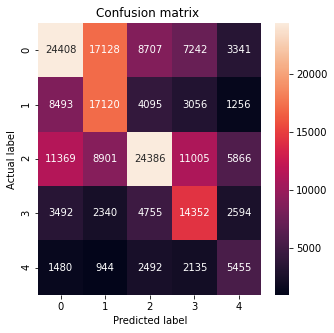

Text(0.5, 24.0, 'Predicted label')

In [0]:
## Generación de la matriz de confusión del modelo de red neuronal #2
cm2 = confusion_matrix(data_preds2["label_true"], data_preds2["label_pred"])
plt.figure(figsize=(5,5))
sns.heatmap(cm2, annot=True, fmt="d")
plt.title('Confusion matrix ')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## 2.3) Red 3: Modelo híbrido entre la red 1 y 2

In [0]:
## Esta tercera red hace entubamiento y entrenamiento separado para los tipos de variables pero de una forma más leve en la que lo hace la red 1 (menos capas). Luego se conectan a una red más profunda común y usa una regularización L2

embedding_vector_length = 32

model1_in = Input(shape=(200,))
emb = Embedding(vocab_size, embedding_vector_length,input_length=200)(model1_in) 
bid = Bidirectional(LSTM(150, return_sequences = True))(emb)
lstm= LSTM (100)(bid)
model1_out = lstm

model2_in = Input(shape=(13,))
dense1=Dense(128,input_shape=(13,))(model2_in)
norma1=BatchNormalization()(dense1)
model2_out = (norma1)

model3_in=Input(shape=(101,))
dense1=Dense(512, activation='relu')(model3_in)
model3_out=(dense1)

concat = concatenate([model1_out, model2_out, model3_out])
dense1= Dense(1024, activation='relu') (concat)
dense2= Dense(512, activation='relu') (dense1)
dense3= Dense(512, activation='relu') (dense2)
dense4= Dense(256, activation='relu') (dense3)
classifier = Dense(128, activation='relu', kernel_regularizer='l2') (dense4)   
out = Dense(5, activation='softmax', name='output_layer')(classifier)

merged_model3 = Model([model1_in, model2_in, model3_in], out)
merged_model3.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', 
metrics=['accuracy'])

print(merged_model3.summary())

Model: "model_12"
__________________________________________________________________________________________________
Layer (type) Output Shape Param # Connected to 
==================================================================================================
input_41 (InputLayer) [(None, 200)] 0 
__________________________________________________________________________________________________
embedding_14 (Embedding) (None, 200, 32) 15347136 input_41[0][0] 
__________________________________________________________________________________________________
input_42 (InputLayer) [(None, 13)] 0 
__________________________________________________________________________________________________
bidirectional_14 (Bidirectional (None, 200, 300) 219600 embedding_14[0][0] 
__________________________________________________________________________________________________
dense_74 (Dense) (None, 128) 1792 input_42[0][0] 
__________________________________________________________________________________________________
input_43 (InputLayer) [(None, 101)] 0 
__________________________________________________________________________________________________
lstm_25 (LSTM) (None, 100) 160400 bidirectional_14[0][0] 
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 128) 512 dense_74[0][0] 
__________________________________________________________________________________________________
dense_75 (Dense) (None, 512) 52224 input_43[0][0] 
__________________________________________________________________________________________________
concatenate_13 (Concatenate) (None, 740) 0 lstm_25[0][0] 
 batch_normalization_9[0][0] 
 dense_75[0][0] 
__________________________________________________________________________________________________
dense_76 (Dense) (None, 1024) 758784 concatenate_13[0][0] 
__________________________________________________________________________________________________
dense_77 (Dense) (None, 512) 524800 dense_76[0][0] 
__________________________________________________________________________________________________
dense_78 (Dense) (None, 512) 262656 dense_77[0][0] 
__________________________________________________________________________________________________
dense_79 (Dense) (None, 256) 131328 dense_78[0][0] 
__________________________________________________________________________________________________
dense_80 (Dense) (None, 128) 32896 dense_79[0][0] 
__________________________________________________________________________________________________
output_layer (Dense) (None, 5) 645 dense_80[0][0] 
==================================================================================================
Total params: 17,492,773
Trainable params: 17,492,517
Non-trainable params: 256
__________________________________________________________________________________________________
None

In [0]:
####Definir class_weight, batch_size y num_epochs y otros parámetros

BATCH_SIZE = 60
NUM_EPOCHS = 40

#Class Weights
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4 }

In [0]:
####Hacer fit del modelo de red # 3 definido
history3 = merged_model3.fit([train_xtext,train_xnumeric, train_xcategoric],y=train_y,validation_split=0.2, epochs=NUM_EPOCHS,class_weight=class_weight,
                           batch_size=BATCH_SIZE,shuffle=True,verbose=1)

2021/09/25 04:09:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '757605d4df2247eb9d7420db62861540', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
Epoch 1/40
 1/9428 [..............................] - ETA: 11:21:22 - loss: 1.7092 - accuracy: 0.1000 2/9428 [..............................] - ETA: 55:18 - loss: 1.6889 - accuracy: 0.1417  3/9428 [..............................] - ETA: 55:32 - loss: 1.6688 - accuracy: 0.1444 4/9428 [..............................] - ETA: 45:47 - loss: 1.6490 - accuracy: 0.1500 5/9428 [..............................] - ETA: 40:13 - loss: 1.6293 - accuracy: 0.1567 6/9428 [..............................] - ETA: 36:15 - loss: 1.6099 - accuracy: 0.1472WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0650s vs `on_train_batch_end` time: 0.1489s). Check your callbacks.
WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0650s vs `on_train_batch_end` time: 0.1489s). Check your callbacks.
 7/9428 [..............................] - ETA: 33:37 - loss: 1.5908 - accuracy: 0.1500 8/9428 [..............................] - ETA: 31:44 - loss: 1.5718 - accuracy: 0.1521 9/9428 [..............................] - ETA: 30:21 - loss: 1.5531 - accuracy: 0.1444 10/9428 [..............................] - ETA: 29:16 - loss: 1.5346 - accuracy: 0.1500 11/9428 [..............................] - ETA: 28:23 - loss: 1.5163 - accuracy: 0.1621 12/9428 [..............................] - ETA: 27:40 - loss: 1.4982 - accuracy: 0.1597 13/9428 [..............................] - ETA: 27:03 - loss: 1.4804 - accuracy: 0.1641 14/9428 [..............................] - ETA: 26:33 - loss: 1.4628 - accuracy: 0.1667 15/9428 [..............................] - ETA: 26:06 - loss: 1.4454 - accuracy: 0.1633 16/9428 [..............................] - ETA: 25:44 - loss: 1.4282 - accuracy: 0.1656 17/9428 [..............................] - ETA: 25:24 - loss: 1.4113 - accuracy: 0.1657 18/9428 [..............................] - ETA: 25:07 - loss: 1.3946 - accuracy: 0.1630 19/9428 [..............................] - ETA: 24:50 - loss: 1.3781 - accuracy: 0.1623

In [0]:
##Aquí se hacen las predicciones del modelo de red neuronal # 3
test_predictions_baseline3 = merged_model3.predict([test_xtext,test_xnumeric, test_xcategoric], batch_size=BATCH_SIZE)
test_predictions_baseline3

data_preds3 = pd.DataFrame({"label_pred": np.argmax(test_predictions_baseline3, axis=1), "label_true":test_y, "pred_0":test_predictions_baseline3[:,0], "pred_1":test_predictions_baseline3[:,1], "pred_2":test_predictions_baseline3[:,2], "pred_3":test_predictions_baseline3[:,3], "pred_4":test_predictions_baseline3[:,4]})

Out[89]:

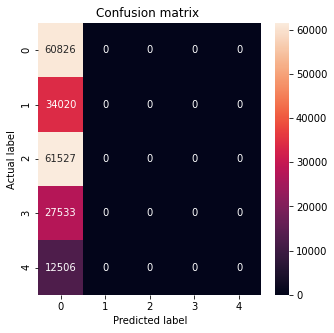

Text(0.5, 24.0, 'Predicted label')

In [0]:
## Generación de la matriz de confusión del modelo de red neuronal #3
cm3 = confusion_matrix(data_preds3["label_true"], data_preds3["label_pred"])
plt.figure(figsize=(5,5))
sns.heatmap(cm3, annot=True, fmt="d")
plt.title('Confusion matrix ')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## 2.4) Red 4: Red 3 sin regularización

In [0]:
## Esta cuarta red hace entubamiento y entrenamiento separado para los tipos de variables pero de una forma más leve en la que lo hace la red 1 (menos capas). Luego se conectan a una red más profunda común pero no usa ninguna regularización a diferencia de la red 3

embedding_vector_length = 32

model1_in = Input(shape=(200,))
emb = Embedding(vocab_size, embedding_vector_length,input_length=200)(model1_in) 
bid = Bidirectional(LSTM(150, return_sequences = True))(emb)
lstm= LSTM (100)(bid)
model1_out = lstm

model2_in = Input(shape=(13,))
dense1=Dense(128,input_shape=(13,))(model2_in)
norma1=BatchNormalization()(dense1)
model2_out = (norma1)

model3_in=Input(shape=(101,))
dense1=Dense(512, activation='relu')(model3_in)
model3_out=(dense1)

concat = concatenate([model1_out, model2_out, model3_out])
dense1= Dense(1024, activation='relu') (concat)
dense2= Dense(512, activation='relu') (dense1)
dense3= Dense(512, activation='relu') (dense2)
dense4= Dense(256, activation='relu') (dense3)
classifier = Dense(128, activation='relu') (dense4)   
out = Dense(5, activation='softmax', name='output_layer')(classifier)

merged_model4 = Model([model1_in, model2_in, model3_in], out)
merged_model4.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', 
metrics=['accuracy'])

print(merged_model4.summary())

Model: "model_13"
__________________________________________________________________________________________________
Layer (type) Output Shape Param # Connected to 
==================================================================================================
input_44 (InputLayer) [(None, 200)] 0 
__________________________________________________________________________________________________
embedding_15 (Embedding) (None, 200, 32) 15347136 input_44[0][0] 
__________________________________________________________________________________________________
input_45 (InputLayer) [(None, 13)] 0 
__________________________________________________________________________________________________
bidirectional_15 (Bidirectional (None, 200, 300) 219600 embedding_15[0][0] 
__________________________________________________________________________________________________
dense_81 (Dense) (None, 128) 1792 input_45[0][0] 
__________________________________________________________________________________________________
input_46 (InputLayer) [(None, 101)] 0 
__________________________________________________________________________________________________
lstm_27 (LSTM) (None, 100) 160400 bidirectional_15[0][0] 
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 128) 512 dense_81[0][0] 
__________________________________________________________________________________________________
dense_82 (Dense) (None, 512) 52224 input_46[0][0] 
__________________________________________________________________________________________________
concatenate_14 (Concatenate) (None, 740) 0 lstm_27[0][0] 
 batch_normalization_10[0][0] 
 dense_82[0][0] 
__________________________________________________________________________________________________
dense_83 (Dense) (None, 1024) 758784 concatenate_14[0][0] 
__________________________________________________________________________________________________
dense_84 (Dense) (None, 512) 524800 dense_83[0][0] 
__________________________________________________________________________________________________
dense_85 (Dense) (None, 512) 262656 dense_84[0][0] 
__________________________________________________________________________________________________
dense_86 (Dense) (None, 256) 131328 dense_85[0][0] 
__________________________________________________________________________________________________
dense_87 (Dense) (None, 128) 32896 dense_86[0][0] 
__________________________________________________________________________________________________
output_layer (Dense) (None, 5) 645 dense_87[0][0] 
==================================================================================================
Total params: 17,492,773
Trainable params: 17,492,517
Non-trainable params: 256
__________________________________________________________________________________________________
None

In [0]:
####Definir class_weight, batch_size y num_epochs y otros parámetros

BATCH_SIZE = 60
NUM_EPOCHS = 40

#Class Weights
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4 }

In [0]:
####Hacer fit del modelo de red # 4 definido
history4 = merged_model4.fit([train_xtext,train_xnumeric, train_xcategoric],y=train_y,validation_split=0.2, epochs=NUM_EPOCHS,class_weight=class_weight,
                           batch_size=BATCH_SIZE,shuffle=True,verbose=1)

2021/09/25 18:48:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6ba49bf5302b4191a5aa328d3998ab50', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
Epoch 1/40
 1/9428 [..............................] - ETA: 11:22:09 - loss: 1.0414e-05 - accuracy: 0.2000 2/9428 [..............................] - ETA: 56:13 - loss: 1.0573e-05 - accuracy: 0.2250  3/9428 [..............................] - ETA: 56:27 - loss: 1.0808e-05 - accuracy: 0.1944 4/9428 [..............................] - ETA: 46:03 - loss: 1.1489e-05 - accuracy: 0.2000 5/9428 [..............................] - ETA: 39:59 - loss: 1.1608e-05 - accuracy: 0.1800 6/9428 [..............................] - ETA: 36:14 - loss: 1.1827e-05 - accuracy: 0.1889WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0644s vs `on_train_batch_end` time: 0.1497s). Check your callbacks.
WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0644s vs `on_train_batch_end` time: 0.1497s). Check your callbacks.
 7/9428 [..............................] - ETA: 33:43 - loss: 1.1801e-05 - accuracy: 0.1929 8/9428 [..............................] - ETA: 31:50 - loss: 1.1851e-05 - accuracy: 0.2000 9/9428 [..............................] - ETA: 30:23 - loss: 1.1880e-05 - accuracy: 0.2019 10/9428 [..............................] - ETA: 29:16 - loss: 1.1881e-05 - accuracy: 0.2033 11/9428 [..............................] - ETA: 28:23 - loss: 1.1876e-05 - accuracy: 0.2076 12/9428 [..............................] - ETA: 27:39 - loss: 1.1903e-05 - accuracy: 0.2083 13/9428 [..............................] - ETA: 27:04 - loss: 1.1935e-05 - accuracy: 0.2115 14/9428 [..............................] - ETA: 26:34 - loss: 1.1940e-05 - accuracy: 0.2131 15/9428 [..............................] - ETA: 26:09 - loss: 1.1866e-05 - accuracy: 0.2111 16/9428 [..............................] - ETA: 25:44 - loss: 1.1783e-05 - accuracy: 0.2094 17/9428 [..............................] - ETA: 25:24 - loss: 1.1774e-05 - accuracy: 0.2108 18/9428 [..............................] - ETA: 25:07 - loss: 1.1813e-05 - accuracy: 0.2102 19/9428 [....................

In [0]:
##Aquí se hacen las predicciones del modelo de red neuronal # 4
test_predictions_baseline4 = merged_model4.predict([test_xtext,test_xnumeric, test_xcategoric], batch_size=BATCH_SIZE)
test_predictions_baseline4

data_preds4 = pd.DataFrame({"label_pred": np.argmax(test_predictions_baseline4, axis=1), "label_true":test_y, "pred_0":test_predictions_baseline4[:,0], "pred_1":test_predictions_baseline4[:,1], "pred_2":test_predictions_baseline4[:,2], "pred_3":test_predictions_baseline4[:,3], "pred_4":test_predictions_baseline4[:,4]})

Out[91]:

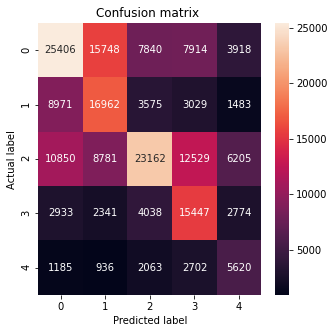

Text(0.5, 24.0, 'Predicted label')

In [0]:
## Generación de la matriz de confusión del modelo de red neuronal #4
cm4 = confusion_matrix(data_preds4["label_true"], data_preds4["label_pred"])
plt.figure(figsize=(5,5))
sns.heatmap(cm4, annot=True, fmt="d")
plt.title('Confusion matrix ')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## 2.5) Red 5: Red 4 entrenada sin pesos iniciales

In [0]:
## Esta quinta red hace entubamiento y entrenamiento separado para los tipos de variables pero de una forma más leve en la que lo hace la red 1 (menos capas). Luego se conectan a una red más profunda común pero no usa ninguna regularización a diferencia de la red 3

model1_in = Input(shape=(200,))
emb = Embedding(vocab_size, embedding_vector_length, input_length=200)(model1_in) 
model1_out = Bidirectional(LSTM(50))(emb)

model2_in = Input(shape=(13,))
model2_out = (model2_in)

model3_in=Input(shape=(101,))
model3_out=(model3_in)

concat = concatenate([model1_out, model2_out, model3_out])
dense1= Dense(1024, activation='relu') (concat)
dense2= Dense(512, activation='relu') (dense1)
dense3= Dense(512, activation='relu') (dense2)
dense4= Dense(256, activation='relu') (dense3)
classifier = Dense(128, activation='relu') (dense4)   
out = Dense(5, activation='softmax', name='output_layer')(classifier)

merged_model5 = Model([model1_in, model2_in, model3_in], out)
merged_model5.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', 
metrics=['accuracy'])

print(merged_model5.summary())


Model: "model_14"
__________________________________________________________________________________________________
Layer (type) Output Shape Param # Connected to 
==================================================================================================
input_47 (InputLayer) [(None, 200)] 0 
__________________________________________________________________________________________________
embedding_16 (Embedding) (None, 200, 32) 15347136 input_47[0][0] 
__________________________________________________________________________________________________
bidirectional_16 (Bidirectional (None, 100) 33200 embedding_16[0][0] 
__________________________________________________________________________________________________
input_48 (InputLayer) [(None, 13)] 0 
__________________________________________________________________________________________________
input_49 (InputLayer) [(None, 101)] 0 
__________________________________________________________________________________________________
concatenate_15 (Concatenate) (None, 214) 0 bidirectional_16[0][0] 
 input_48[0][0] 
 input_49[0][0] 
__________________________________________________________________________________________________
dense_88 (Dense) (None, 1024) 220160 concatenate_15[0][0] 
__________________________________________________________________________________________________
dense_89 (Dense) (None, 512) 524800 dense_88[0][0] 
__________________________________________________________________________________________________
dense_90 (Dense) (None, 512) 262656 dense_89[0][0] 
__________________________________________________________________________________________________
dense_91 (Dense) (None, 256) 131328 dense_90[0][0] 
__________________________________________________________________________________________________
dense_92 (Dense) (None, 128) 32896 dense_91[0][0] 
__________________________________________________________________________________________________
output_layer (Dense) (None, 5) 645 dense_92[0][0] 
==================================================================================================
Total params: 16,552,821
Trainable params: 16,552,821
Non-trainable params: 0
__________________________________________________________________________________________________
None

In [0]:
####Definir  batch_size y num_epochs

BATCH_SIZE = 60
NUM_EPOCHS = 40


In [0]:
##Hacer fit de la red 5 sin pesos iniciales (no class_weight)
history5 = merged_model5.fit([train_xtext,train_xnumeric, train_xcategoric],y=train_y,validation_split=0.2, epochs=NUM_EPOCHS,
                           batch_size=BATCH_SIZE,shuffle=True,verbose=1)

2021/09/26 09:30:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0125aaecf37948f38d43910c9272f99d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
Epoch 1/40
 1/9428 [..............................] - ETA: 7:30:38 - loss: 1.5677 - accuracy: 0.3667 2/9428 [..............................] - ETA: 30:49 - loss: 1.4776 - accuracy: 0.4167  3/9428 [..............................] - ETA: 44:42 - loss: 1.6307 - accuracy: 0.3722 4/9428 [..............................] - ETA: 34:22 - loss: 1.5579 - accuracy: 0.3833 5/9428 [..............................] - ETA: 29:18 - loss: 1.5247 - accuracy: 0.3933 6/9428 [..............................] - ETA: 26:16 - loss: 1.5019 - accuracy: 0.3917WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0417s vs `on_train_batch_end` time: 0.1076s). Check your callbacks.
WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0417s vs `on_train_batch_end` time: 0.1076s). Check your callbacks.
 7/9428 [..............................] - ETA: 24:02 - loss: 1.5006 - accuracy: 0.3738 8/9428 [..............................] - ETA: 22:25 - loss: 1.4885 - accuracy: 0.3854 9/9428 [..............................] - ETA: 21:08 - loss: 1.4938 - accuracy: 0.3778 10/9428 [..............................] - ETA: 20:10 - loss: 1.4861 - accuracy: 0.3917 11/9428 [..............................] - ETA: 19:17 - loss: 1.4832 - accuracy: 0.3955 12/9428 [..............................] - ETA: 18:35 - loss: 1.4870 - accuracy: 0.3889 13/9428 [..............................] - ETA: 17:59 - loss: 1.4841 - accuracy: 0.3846 14/9428 [..............................] - ETA: 17:28 - loss: 1.4790 - accuracy: 0.3845 15/9428 [..............................] - ETA: 17:01 - loss: 1.4669 - accuracy: 0.3878 16/9428 [..............................] - ETA: 16:35 - loss: 1.4555 - accuracy: 0.3927 17/9428 [..............................] - ETA: 16:14 - loss: 1.4531 - accuracy: 0.3902 18/9428 [..............................] - ETA: 15:54 - loss: 1.4543 - accuracy: 0.3870 19/9428 [..............................] - ETA: 15:35 - loss: 1.4552 - accuracy: 0.3877

In [0]:
##Aquí se hacen las predicciones del modelo de red neuronal # 5 entrenado sin class_weight
test_predictions_baseline5 = merged_model5.predict([test_xtext,test_xnumeric, test_xcategoric], batch_size=BATCH_SIZE)
test_predictions_baseline5

data_preds5 = pd.DataFrame({"label_pred": np.argmax(test_predictions_baseline5, axis=1), "label_true":test_y, "pred_0":test_predictions_baseline5[:,0], "pred_1":test_predictions_baseline5[:,1], "pred_2":test_predictions_baseline5[:,2], "pred_3":test_predictions_baseline5[:,3], "pred_4":test_predictions_baseline5[:,4]})

Out[95]:

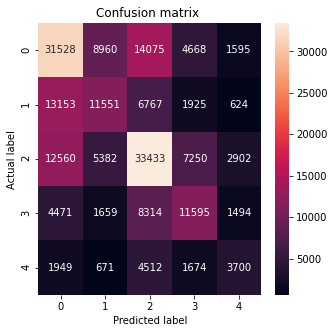

Text(0.5, 24.0, 'Predicted label')

In [0]:
## Generación de la matriz de confusión del modelo de red neuronal #5
cm5 = confusion_matrix(data_preds5["label_true"], data_preds5["label_pred"])
plt.figure(figsize=(5,5))
sns.heatmap(cm5, annot=True, fmt="d")
plt.title('Confusion matrix ')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# 3) Guardar y exportar los modelos entrenados
No se guarda la red 3 debido a que su ajuste es muy bajo

In [0]:
### Guardando la red 1
import mlflow
model_name = "red_1"
new_model_version = mlflow.register_model(f"runs:/92e52e8a819f46c984e0778b87ab1223/model", model_name)

Registered model 'red_1' already exists. Creating a new version of this model...
2021/09/27 20:21:44 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: red_1, version 2
Created version '2' of model 'red_1'.

In [0]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=new_model_version.version,
  stage="Staging",
)

Out[6]: <ModelVersion: creation_timestamp=1632774104374, current_stage='Staging', description='', last_updated_timestamp=1632774119922, name='red_1', run_id='92e52e8a819f46c984e0778b87ab1223', run_link='', source='dbfs:/databricks/mlflow-tracking/157791148283839/92e52e8a819f46c984e0778b87ab1223/artifacts/model', status='READY', status_message='', tags={}, user_id='3226046456706387', version='2'>

In [0]:
from mlflow.store.artifact.models_artifact_repo import ModelsArtifactRepository

modelpath = "/dbfs/mnt/basecruzada/Red1"

local_path = ModelsArtifactRepository(
  f'models:/{model_name}/Staging').download_artifacts("", dst_path=modelpath)

In [0]:
### Guardando y exportando la red #2

import mlflow
from mlflow.tracking import MlflowClient
from mlflow.store.artifact.models_artifact_repo import ModelsArtifactRepository

model_name = "red_2"
new_model_version = mlflow.register_model(f"runs:/00a8054313494e63adcba02036d286f2/model", model_name)

client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=new_model_version.version,
  stage="Staging",
)


modelpath = "/dbfs/mnt/basecruzada/Red2"
local_path = ModelsArtifactRepository(
  f'models:/{model_name}/Staging').download_artifacts("", dst_path=modelpath)



Registered model 'red_2' already exists. Creating a new version of this model...
2021/09/27 20:23:55 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: red_2, version 2
Created version '2' of model 'red_2'.

In [0]:
## Guardando y exportando la red #4
model_name = "red_4"
new_model_version = mlflow.register_model(f"runs:/6ba49bf5302b4191a5aa328d3998ab50/model", model_name)

client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=new_model_version.version,
  stage="Staging",
)


modelpath = "/dbfs/mnt/basecruzada/Red4"
local_path = ModelsArtifactRepository(
  f'models:/{model_name}/Staging').download_artifacts("", dst_path=modelpath)


Registered model 'red_4' already exists. Creating a new version of this model...
2021/09/27 20:24:56 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: red_4, version 2
Created version '2' of model 'red_4'.

In [0]:
## Guardando y exportando la red #5 (red 4 entrenada sin class_weight)
model_name = "red_5"
new_model_version = mlflow.register_model(f"runs:/0125aaecf37948f38d43910c9272f99d/model", model_name)

client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=new_model_version.version,
  stage="Staging",
)


modelpath = "/dbfs/mnt/basecruzada/Red5"
local_path = ModelsArtifactRepository(
  f'models:/{model_name}/Staging').download_artifacts("", dst_path=modelpath)

Registered model 'red_5' already exists. Creating a new version of this model...
2021/09/27 20:25:37 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: red_5, version 2
Created version '2' of model 'red_5'.

# 4) Cargar modelos pre-entrenados y exportados

In [0]:
##El siguiente código se usa para hacer load a un modelo preentrenado
path1 = "/dbfs/mnt/basecruzada/Red1/data/model"
path2 = "/dbfs/mnt/basecruzada/Red2/data/model"
path4= "/dbfs/mnt/basecruzada/Red4/data/model"
path5= "/dbfs/mnt/basecruzada/Red5/data/model"

red1 = tf.keras.models.load_model(path1)
red2 = tf.keras.models.load_model(path2)
red4 = tf.keras.models.load_model(path4)
red5 = tf.keras.models.load_model(path5)

In [0]:
## Predict sobre los 4 modelos cargados

test_predictions_baseline1 = red1.predict([test_xtext,test_xnumeric, test_xcategoric], batch_size=32)

test_predictions_baseline2 = red2.predict([test_xtext,test_xnumeric, test_xcategoric], batch_size=60)

test_predictions_baseline4 = red4.predict([test_xtext,test_xnumeric, test_xcategoric], batch_size=60)

test_predictions_baseline5 = red5.predict([test_xtext,test_xnumeric, test_xcategoric], batch_size=60)

data_preds1 = pd.DataFrame({"label_pred_red1": np.argmax(test_predictions_baseline1, axis=1), "label_true":test_y, "pred_0_red1":test_predictions_baseline1[:,0], "pred_1_red1":test_predictions_baseline1[:,1], "pred_2_red1":test_predictions_baseline1[:,2], "pred_3_red1":test_predictions_baseline1[:,3], "pred_4_red1":test_predictions_baseline1[:,4]})

data_preds2 = pd.DataFrame({"label_pred_red2": np.argmax(test_predictions_baseline2, axis=1), "label_true":test_y, "pred_0_red2":test_predictions_baseline2[:,0], "pred_1_red2":test_predictions_baseline2[:,1], "pred_2_red2":test_predictions_baseline2[:,2], "pred_3_red2":test_predictions_baseline2[:,3], "pred_4_red2":test_predictions_baseline2[:,4]})

data_preds4 = pd.DataFrame({"label_pred_red4": np.argmax(test_predictions_baseline4, axis=1), "label_true":test_y, "pred_0_red4":test_predictions_baseline4[:,0], "pred_1_red4":test_predictions_baseline4[:,1], "pred_2_red4":test_predictions_baseline4[:,2], "pred_3_red4":test_predictions_baseline4[:,3], "pred_4_red4":test_predictions_baseline4[:,4]})

data_preds5 = pd.DataFrame({"label_pred_red5": np.argmax(test_predictions_baseline5, axis=1), "label_true":test_y, "pred_0_red5":test_predictions_baseline5[:,0], "pred_1_red5":test_predictions_baseline5[:,1], "pred_2_red5":test_predictions_baseline5[:,2], "pred_3_red5":test_predictions_baseline5[:,3], "pred_4_red5":test_predictions_baseline5[:,4]})

In [0]:
# Se concatenan los predicts para hacer exportación de sus métricas 
df=pd.concat([data_preds1,data_preds2,data_preds4,data_preds5], axis=1)
df.head()

Out[29]:

,label_pred_red1,label_true,pred_0_red1,pred_1_red1,pred_2_red1,pred_3_red1,pred_4_red1,label_pred_red2,label_true,pred_0_red2,pred_1_red2,pred_2_red2,pred_3_red2,pred_4_red2,label_pred_red4,label_true,pred_0_red4,pred_1_red4,pred_2_red4,pred_3_red4,pred_4_red4,label_pred_red5,label_true,pred_0_red5,pred_1_red5,pred_2_red5,pred_3_red5,pred_4_red5
220392,0,2,0.363722,0.294009,0.283329,0.021770,3.717037e-02,0,2,0.562794,0.066377,0.370777,0.000030,2.144311e-05,2,2,0.206943,0.304061,0.456268,0.019979,1.274933e-02,0,2,0.999833,5.964445e-07,0.000165,1.465580e-09,0.000002
320601,2,0,0.173660,0.008806,0.485634,0.331900,1.034086e-10,0,0,0.662583,0.000204,0.337209,0.000004,2.343772e-14,2,0,0.349861,0.000170,0.631067,0.018902,4.446646e-07,0,0,0.838154,1.104510e-02,0.150678,1.265910e-06,0.000122
748779,0,3,0.455136,0.364742,0.136918,0.040221,2.983300e-03,1,3,0.021973,0.949109,0.028009,0.000834,7.452148e-05,1,3,0.050652,0.780329,0.129025,0.038900,1.093173e-03,1,3,0.320887,5.089438e-01,0.157808,9.364588e-03,0.002997
855220,0,2,0.402804,0.189951,0.390673,0.016320,2.524625e-04,0,2,0.507948,0.017772,0.244462,0.229815,2.616954e-06,2,2,0.312100,0.001302,0.557833,0.128765,1.148110e-09,3,2,0.008674,1.547659e-04,0.011308,9.791209e-01,0.000742
320075,3,3,0.105760,0.036952,0.342334,0.514891,6.241121e-05,0,3,0.579425,0.024481,0.330088,0.065738,2.673637e-04,3,3,0.063931,0.036758,0.168167,0.731143,2.808383e-08,2,3,0.004237,4.621483e-03,0.981545,9.149515e-03,0.000447


In [0]:
## Se exporta a excel el dataframe concatenado que contiene los predict de los 4 modelos
from shutil import copyfile
final = '/dbfs/mnt/basecruzada/results_redes.xlsx'
temp_file = '/tmp/results_redes.xlsx'
df.to_excel(temp_file, engine='openpyxl')
copyfile(temp_file, final)


Out[42]: '/dbfs/mnt/sample/results_redes.xlsx'